# Домашнее задание №6: "Детекция объектов на изображении"

**ФИО:** Ковалишин Никита Игоревич

**Группа:** ML-22

**Цель задания:** Научиться самостоятельно решать задачу детекции

**Описание задания:** В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели.

**Что нужно сделать в задании:**

В рамках данного домашнего задания предлагается решить задачу детекции бабочек и настроить полный пайплайн обучения модели.


0) Выбор модели детекции для обучения:
    - Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную (в этом случае в пункте 4. показать влияние предобучения на финальное качество).

1) Подготовка обучающего набора данных:
    - Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера), (0.5 балла);
    - Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box), (0.5 балла);
    - Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.), (0.5 балла).

2) Реализация корректного train-loop и обучение модели:
    - Реализуйте эффективный train-loop для вашей модели и проведите обучение (2 балла).
    - Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор), (0.5 балла).

3) Валидация обученных моделей на тестовой выборке, вычисление метрики mAP:
    Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP (0.5 балла).

4) Выводы (0.5 балла):
    Проанализируйте результаты обучения, визуально оцените качество работы модели.
    Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.


Аннотация:

- Выбран детектор fasterrcnn_resnet50_fpn, обученный на датасете COCO;

- Датасет COCO содержит 90 классов, на которых можно обучать модели. В данном домашнем задании предлагается дообучить модель, обученную на датасете COCO, на какой-нибудь другой класс, не входящий в COCO;

- В данном домашнем задании модель будет дообучаться на классе бабочек (этого класса нет в COCO, но есть в Open Images v7);

- Для загрузки изображений с бабочками и bounding box'ами будет скачан специальный модуль fiftyone.

## Подключение всех необходимых модулей и вспомогательных функций

In [ ]:
!pip install fiftyone
import fiftyone as fo
import numpy as np
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torch
from torch.utils.data import ConcatDataset, DataLoader
import PIL
from PIL import Image
import json
import os
from google.colab import output
import math
import sys
import time

def ShowImage(image, figsize=(8, 4), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#функция сохраняет изображения в локальную директорию и из директории монтирует их в dict вместе с box'ами
def SaveImagesAndBoxesFromV7(v7Dataset, pathToSave, label):
  if(not(os.path.exists(pathToSave))):
    os.makedirs(pathToSave)
  boxesDict = {}
  for sample in v7Dataset:
    filename = os.path.basename(sample.filepath)
    img = Image.open(sample.filepath)
    w, h = img.size
    detections = sample.ground_truth.detections
    boxesCoords = []
    for detection in detections:
      if detection.label == label:
        xMin = detection.bounding_box[0] * w
        yMin = detection.bounding_box[1] * h
        xMax = (detection.bounding_box[0] + detection.bounding_box[2]) * w
        yMax = (detection.bounding_box[1] + detection.bounding_box[3]) * h
        boxesCoords += [[xMin, yMin, xMax, yMax]]#pascal_voc format
    savingPath = os.path.join(pathToSave, filename)
    boxesDict[savingPath] = boxesCoords
    img.save(savingPath)
  return boxesDict

def ShowImageWithBox(
                     file, boxesDict,
                     transform=None,
                     isSimpleTransform=True,
                     minPixValAfterTransform=0.0,
                     maxPixValAfterTransform=255.0
                    ):
  img = cv2.imread(file, cv2.COLOR_BGR2RGB) #np.array (H, W, C)
  boundingBoxes = boxesDict[file]
  if transform is not None:
    if isSimpleTransform:
      transformedItem = transform(image=img)
    else:
      transformedItem = transform(
                                  image=img,
                                  bboxes=boundingBoxes,
                                  category_ids=list(
                                                    np.ones(
                                                            len(boundingBoxes),
                                                            dtype=np.int64
                                                           )
                                                   )
                                 )
      boundingBoxes = transformedItem['bboxes']
    img = transformedItem['image']
    if torch.is_tensor(img):# в таком случае img будет torch.tensor (C, H, W)
      img = transformedItem['image'].numpy().transpose(1, 2, 0)
  img = (img - minPixValAfterTransform) / (maxPixValAfterTransform - minPixValAfterTransform)
  for i in range(len(boundingBoxes)):
    xMin, yMin, xMax, yMax = boundingBoxes[i]
    xMin, yMin, xMax, yMax = int(xMin), int(yMin), int(xMax), int(yMax)
    cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0, 1.0, 0), 2)
  ShowImage(img)

def PlotTrainingAndValStatistics(lossesLists, mAPLists, listsLabels, statisticsType):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  for i in range(len(listsLabels)):
    plt.plot(lossesLists[i], label=listsLabels[i])
  plt.title(statisticsType + ' Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=0, fontsize=16)
  plt.tight_layout()
  plt.grid()

  plt.subplot(1, 2, 2)
  for i in range(len(listsLabels)):
    plt.plot(mAPLists[i], label=listsLabels[i])
  plt.title(statisticsType + ' mAP')
  plt.xlabel('Epoch')
  plt.ylabel('mAP')
  plt.legend(loc=0, fontsize=16)
  plt.tight_layout()
  plt.grid()

  plt.show()

output.clear()

## Подготовка обучающего и валидационного набора данных

### Загрузка изображений нового класса для обучения и валидации

In [ ]:
#монтируем образы изображений бабочек из open-images-v7 в датасеты для train и val
#для train загружаем 4000 картинок
datasetTrain = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="train",
              label_types=["detections"],
              classes=["Butterfly"],
              max_samples=4000,
          )
#для валидации 200 картинок
datasetVal = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="test",
              label_types=["detections"],
              classes=["Butterfly"],
              max_samples=200,
          )
datasetTrain.persistent = True
datasetVal.persistent = True
bbButterfliesDictTrain = SaveImagesAndBoxesFromV7(datasetTrain, '/content/butterflies/train/', "Butterfly")
bbButterfliesDictVal = SaveImagesAndBoxesFromV7(datasetVal, '/content/butterflies/validation/', "Butterfly")
output.clear()

Проверка размера словарей датасетов:

In [ ]:
print("The size of bounding box train dictionary: ", len(bbButterfliesDictTrain))
print("The size of bounding box validation dictionary: ", len(bbButterfliesDictVal))

The size of bounding box train dictionary:  4000
The size of bounding box validation dictionary:  200


### Как выглядят изображения c box'ами

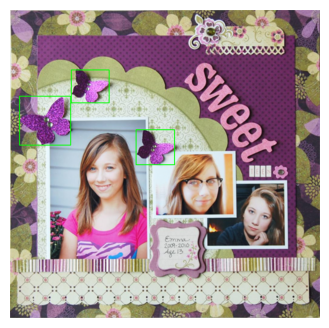

In [ ]:
valFilenames = list(bbButterfliesDictVal.keys())
filename = np.random.choice(valFilenames)
ShowImageWithBox(filename, bbButterfliesDictVal)

### Создадим класс датасета (который подходит для выбранной модели)

In [ ]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, boxesDict, transforms=None, isSimpleTransform=True):
      self.transforms = transforms
      self.boxesDict = boxesDict
      self.imgs = list(self.boxesDict.keys())
      self.isSimpleTransform = isSimpleTransform

    def __getitem__(self, idx):
      # load images and masks
      imgPath = self.imgs[idx]
      img = Image.open(imgPath).convert("RGB")
      numObjs = len(self.boxesDict[imgPath])
      boxesLst = []
      for i in range(numObjs):
        bBox = self.boxesDict[imgPath][i]
        xMin, yMin, xMax, yMax = bBox[0], bBox[1], bBox[2], bBox[3]
        boxesLst.append([xMin, yMin, xMax, yMax])
      boxesLst = torch.as_tensor(boxesLst, dtype=torch.float32)
      labels = torch.ones((numObjs,), dtype=torch.int64) # there is only one class
      imageId = torch.tensor([idx])
      target = {}
      if self.transforms is not None:
        if not(self.isSimpleTransform):
          transformedItem = self.transforms(image=np.array(img),
                                            bboxes=boxesLst,
                                            category_ids=list(np.ones(len(labels), dtype=np.int64))
                                            )
          target["boxes"] = torch.as_tensor(transformedItem['bboxes'], dtype=torch.float32)
          target["labels"] = labels
          target["image_id"] = imageId
          return transformedItem['image'], target
        transformedItem = self.transforms(image=np.array(img))
        img = transformedItem['image']
      target["boxes"] = boxesLst
      target["labels"] = labels
      target["image_id"] = imageId
      return img, target

    def __len__(self):
      return len(self.imgs)

Класс загрузчика данных создавать не нужно, хватит стандартного класса DataLoader из torch.utils.data.

### Аугментации (простые и сложные)

In [ ]:
identityTransform = transforms.Compose(
    [
    transforms.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.), max_pixel_value=255.),
    ToTensorV2()
    ]
)
simpleTransform = transforms.Compose(
    [
    transforms.RandomBrightnessContrast(p=1.0),
    transforms.GaussNoise(p=0.5),
    transforms.GaussianBlur(p=0.7),
    transforms.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.), max_pixel_value=255.),
    ToTensorV2()
    ]
)
hardTransform = transforms.Compose(
    [
    transforms.Affine(rotate=(-1, 1), scale=(0.5, 1.5), translate_percent=(0.0, 0.1), p=1.0),
    transforms.HorizontalFlip(p=1),
    transforms.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.), max_pixel_value=255.),
    ToTensorV2()
    ],
    bbox_params = transforms.BboxParams(format='pascal_voc', label_fields=['category_ids'], min_visibility=0.3)
)

## Реализация корректного train-loop и обучение модели

### Вспомогательные функции для данного раздела

In [ ]:
def CalculateIOU(predBox, targetBox):
  xMinI = max(predBox[0], targetBox[0])
  yMinI = max(predBox[1], targetBox[1])
  xMaxI = min(predBox[2], targetBox[2])
  yMaxI = min(predBox[3], targetBox[3])
  wI = max(0, xMaxI - xMinI)
  hI = max(0, yMaxI - yMinI)
  iArea = wI * hI
  predBArea = (predBox[2] - predBox[0]) * (predBox[3] - predBox[1])
  targetBArea = (targetBox[2] - targetBox[0]) * (targetBox[3] - targetBox[1])
  return iArea / (predBArea + targetBArea - iArea)

#считает AP для одного класса
def CalculateAP(predBoxes, predScores, targetBoxes, matchThreshold=0.5):
  #сортировка box'ов по скору
  if predScores is not None and len(predScores) > 0:
    if len(targetBoxes) == 0: return 0.0
    sortedIdx = np.argsort(np.array(predScores))[::-1]
    predBoxes = np.array(predBoxes)[sortedIdx]
    predScores = np.array(predScores)[sortedIdx]
  else:
    if len(targetBoxes) == 0: return 1.0
    else: return 0.0
  #выделяем индикаторную память для каждого predicted box
  # + гарантируем согласование (? tpIMem[i] == 1 : fpIMem[i] == 0, fpIMem[i] == 1)
  tpIMem = np.zeros(len(predBoxes))
  fpIMem = np.zeros(len(predBoxes))
  #выделяем память состояний (? is prediction found: True, False) для каждого target box
  predFoundMem = np.zeros(len(targetBoxes))
  #обыкновенная динамика по predFoundMem:
  # - если IOU_max < threshold для predBox fpIMem[predBox] = 1,
  # - если IOU_max >= threshold, то
  # -- если предсказание для этого таргета было найдено раньше, то fpIMem[predBox] = 1,
  # -- иначе tpIMem[predBox] = 1.
  for i, predBox in enumerate(predBoxes):
    matchMetrics = np.array([CalculateIOU(predBox, targetBox) for targetBox in targetBoxes])
    maxMMetricIdx = np.argmax(matchMetrics)
    if matchMetrics[maxMMetricIdx] >= matchThreshold:
      if predFoundMem[maxMMetricIdx] == 0:
        predFoundMem[maxMMetricIdx] = 1
        tpIMem[i] = 1
      else: fpIMem[i] = 1
    else: fpIMem[i] = 1
  #вычисление осей precision и recall для моделирования кривой precision-recall:
  tpAccMem, fpAccMem = np.cumsum(tpIMem), np.cumsum(fpIMem)
  precisionAxis = tpAccMem / (tpAccMem + fpAccMem + 1e-8)
  recallAxis = tpAccMem / (len(targetBoxes) + 1e-8)
  #численно вычисляется интеграл precision-recall на сетке с шагом 1/100.
  #этот шаг не я придумал, там, где я читал, рекомендовали такой шаг брать.
  avgP = 0.0
  for rec in np.linspace(0, 1, 101):
    if np.sum(recallAxis >= rec) > 0:
      #максимум берётся из-за нестабильности precision-recall кривой
      #Всё равно дальше как правило идёт стабилизация (если модель адекватная и не склонна к переобучению)
      pr = np.max(precisionAxis[recallAxis >= rec])
      avgP += pr / 101
  return avgP

# collate_fn needs for batch
def collate_fn(batch):
  return tuple(zip(*batch))

#загрузчик объекта модели-детектора fasterrcnn_resnet50_fpn, обученного на COCO
def LoadFasterRCNNModel():
  model = fasterrcnn_resnet50_fpn(
                                  weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1,
                                  progress=True
                                 )
  inChannels = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(
                                                    in_channels=inChannels,
                                                    num_classes=2
                                                   )
  return model

#включение параметров модуля Region Proposal и Head для обучения
def TurnTrainRegPropAndHead(model):
  for param in model.parameters():
    param.requires_grad = True
  for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

#создание оптимизатора для объекта модели (нужные параметры должны быть подключены)
def CreateOptimForFasterRCNN(model):
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005,
                              momentum=0.9, weight_decay=0.0005)
  return optimizer

### Создание и настройка объектов, необходимых для обучения

In [ ]:
#датасеты
trainDatasetOrig = DetectionDataset(bbButterfliesDictTrain, identityTransform)
trainDatasetSimpleAugmented = DetectionDataset(bbButterfliesDictTrain, simpleTransform)
trainDatasetHardAugmented = DetectionDataset(bbButterfliesDictTrain, hardTransform, isSimpleTransform=False)
trainDatasetWthSimpleAugs = ConcatDataset([trainDatasetOrig, trainDatasetSimpleAugmented])
trainDatasetWthHardAugs = ConcatDataset([trainDatasetOrig, trainDatasetHardAugmented])
trainDatasetWthAllAugs = ConcatDataset([
                                        trainDatasetOrig,
                                        trainDatasetSimpleAugmented,
                                        trainDatasetHardAugmented
                                       ])
valDataset = DetectionDataset(bbButterfliesDictVal, identityTransform)

In [ ]:
# Loader оригинального датасета:
trainLoaderOrig = DataLoader(
                             trainDatasetOrig,
                             batch_size=8,
                             shuffle=True,
                             num_workers=12,
                             collate_fn=collate_fn,
                             drop_last=True
                            )

#Loader с простыми аугментациями, не затрагивающими boundong box:
trainLoaderWthSimpleAugs = DataLoader(
                                      trainDatasetWthSimpleAugs,
                                      batch_size=8,
                                      shuffle=True,
                                      num_workers=12,
                                      collate_fn=collate_fn,
                                      drop_last=True
                                     )

#Loader с аугментациями, затрагивающими boundong box:
trainLoaderWthHardAugs = DataLoader(
                                    trainDatasetWthHardAugs,
                                    batch_size=8,
                                    shuffle=True,
                                    num_workers=12,
                                    collate_fn=collate_fn,
                                    drop_last=True
                                   )

#Loader со всеми аугментациями:
trainLoaderWthAllAugs = DataLoader(
                                   trainDatasetWthAllAugs,
                                   batch_size=8,
                                   shuffle=True,
                                   num_workers=12,
                                   collate_fn=collate_fn,
                                   drop_last=True
                                  )

valLoader = DataLoader(
                       valDataset,
                       batch_size=1,
                       shuffle=False,
                       num_workers=1,
                       collate_fn=collate_fn,
                       drop_last=False
                      )

In [ ]:
# создание объектов моделей для обучения на соответствующих данных
modelForOrigTraining = LoadFasterRCNNModel()
modelForSimpleAugTraining = LoadFasterRCNNModel()
modelForHardAugTraining = LoadFasterRCNNModel()
modelForAllAugTraining = LoadFasterRCNNModel()

# включение параметров модулей Region Proposal и Head для обучения
TurnTrainRegPropAndHead(modelForOrigTraining)
TurnTrainRegPropAndHead(modelForSimpleAugTraining)
TurnTrainRegPropAndHead(modelForHardAugTraining)
TurnTrainRegPropAndHead(modelForAllAugTraining)

# создание объектов оптимизаторов для каждой модели
optimForOrig = CreateOptimForFasterRCNN(modelForOrigTraining)
optimForSimpleAug = CreateOptimForFasterRCNN(modelForSimpleAugTraining)
optimForHardAug = CreateOptimForFasterRCNN(modelForHardAugTraining)
optimForAllAug = CreateOptimForFasterRCNN(modelForAllAugTraining)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 214MB/s]


### Train-loop с валидационной проверкой для обучения моделей

In [ ]:
def trainFasterRCNN(model, optimizer, trainLoader, valLoader, device, numEpochs=10):
  model.to(device);
  model.train()
  trainLossLst, valLossLst = [], []
  trainMAPLst, valMAPLst = [], []
  for epoch in tqdm.tqdm_notebook(range(numEpochs)):
    epochLossValue, epochMAP = 0, 0
    for images, targets in tqdm.tqdm_notebook(trainLoader):
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      # получим предсказания сети (словарь)
      # cложим их
      lossDict = model(images, targets)
      losses = sum([value for value in lossDict.values()]) / trainLoader.batch_size
      epochLossValue += losses.item()
      if not math.isfinite(epochLossValue):
        print("Loss is {}, stopping training".format(epochLossValue))
        sys.exit(1)
      with torch.no_grad():
        model.eval()
        predictions = model(images)
        for i in range(trainLoader.batch_size):
          epochMAP += CalculateAP(
                                  predictions[i]['boxes'].cpu(),
                                  predictions[i]['scores'].cpu(),
                                  targets[i]['boxes'].cpu()
                                 )
        model.train()
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
    trainLossLst += [epochLossValue / len(trainLoader)]
    trainMAPLst += [epochMAP / (len(trainLoader) * trainLoader.batch_size)]
    print("Train Loss: ", trainLossLst[-1])
    print("Train mAP: ", trainMAPLst[-1])
    #Валидация. model.eval() не вызван специально, так как для валидации нам нужны только Loss'ы,
    #которые могут выводиться только в train-режиме. Loss будет считаться корректно,
    #так как в FasterRCNN_Resnet50 нет зависящих от режима модулей BatchNorm и DropOut
    #Есть FrozenBatchNorm, но он работает одинаково что в model.train(), что в model.eval().
    epochLossValue, epochMAP = 0, 0
    with torch.no_grad():
      for images, targets in valLoader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        lossDict = model(images, targets)
        losses = sum([value for value in lossDict.values()]) / valLoader.batch_size
        epochLossValue += losses.item()
        model.eval()
        predictions = model(images)
        for i in range(valLoader.batch_size):
          epochMAP += CalculateAP(
                                  predictions[i]['boxes'].cpu(),
                                  predictions[i]['scores'].cpu(),
                                  targets[i]['boxes'].cpu()
                                 )
        model.train()
    valLossLst += [epochLossValue / len(valLoader)]
    valMAPLst += [epochMAP / (len(valLoader) * valLoader.batch_size)]
    print("Validation Loss: ", valLossLst[-1])
    print("Validation mAP: ", valMAPLst[-1])
  model.to('cpu')
  return trainLossLst, valLossLst, trainMAPLst, valMAPLst

### Подключение устройства

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Обучение модели на оригинальных данных:

In [ ]:
trainLossLstOrig, \
valLossLstOrig, \
trainMAPLstOrig, \
valMAPLstOrig = trainFasterRCNN(modelForOrigTraining,
                                optimForOrig,
                                trainLoaderOrig,
                                valLoader,
                                device)
output.clear()

### Обучение модели на данных с простыми аугментациями (не затрагивающие bounding box'ы)

In [ ]:
trainLossLstSimpleAugs, \
valLossLstSimpleAugs, \
trainMAPLstSimpleAugs, \
valMAPLstSimpleAugs = trainFasterRCNN(modelForSimpleAugTraining,
                                      optimForSimpleAug,
                                      trainLoaderWthSimpleAugs,
                                      valLoader,
                                      device)
output.clear()

### Обучение модели на данных со сложными аугментациями (затрагивающие bounding box'ы)

In [ ]:
trainLossLstHardAugs, \
valLossLstHardAugs, \
trainMAPLstHardAugs, \
valMAPLstHardAugs = trainFasterRCNN(modelForHardAugTraining,
                                    optimForHardAug,
                                    trainLoaderWthHardAugs,
                                    valLoader,
                                    device)
output.clear()

### Обучение модели на данных со всеми аугментациями

In [ ]:
trainLossLstAllAugs, \
valLossLstAllAugs, \
trainMAPLstAllAugs, \
valMAPLstAllAugs = trainFasterRCNN(modelForAllAugTraining,
                                   optimForAllAug,
                                   trainLoaderWthAllAugs,
                                   valLoader,
                                   device)
output.clear()

## Обзор результатов

### Подготовка формата данных для передачи в функцию отображения статистики:

In [ ]:
lossesListsTrain = [trainLossLstOrig,
                    trainLossLstSimpleAugs,
                    trainLossLstHardAugs,
                    trainLossLstAllAugs]
mAPListsTrain = [trainMAPLstOrig,
                 trainMAPLstSimpleAugs,
                 trainMAPLstHardAugs,
                 trainMAPLstAllAugs]
lossesListsVal = [valLossLstOrig,
                  valLossLstSimpleAugs,
                  valLossLstHardAugs,
                  valLossLstAllAugs]
mAPListsVal = [valMAPLstOrig,
               valMAPLstSimpleAugs,
               valMAPLstHardAugs,
               valMAPLstAllAugs]
listsLabels = ['Original', 'With simple augs', 'With hard augs', 'With all augs']

### Статистика обучения на train'е:

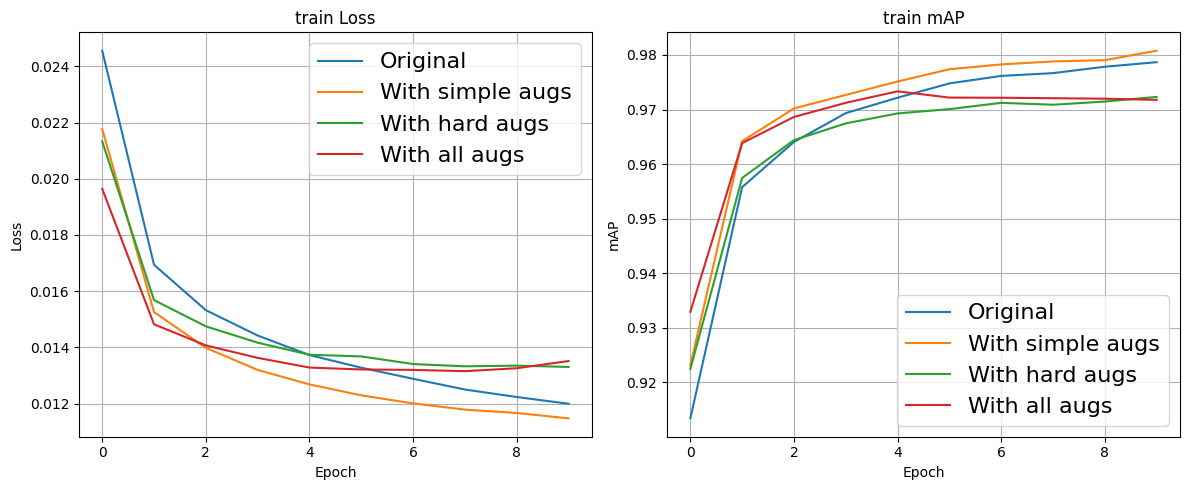

In [ ]:
PlotTrainingAndValStatistics(lossesListsTrain, mAPListsTrain, listsLabels, 'train')

### Статистика обучения на валидации:

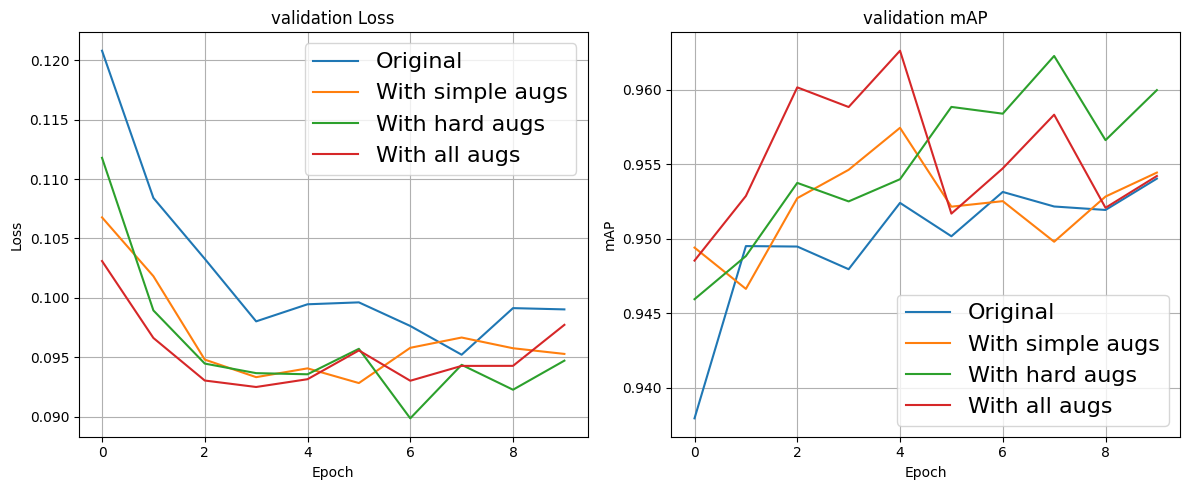

In [ ]:
PlotTrainingAndValStatistics(lossesListsVal, mAPListsVal, listsLabels, 'validation')

В целом, по статистике обучения можно сказать, что аугментации помогли. Но чётко сказать, какая из них лучше нельзя. Для более детального анализа лучше посмотреть визуально на результат.

### Визуализация предсказаний для валидации

In [ ]:
def VisualizePredictionPlate(file, model, device='cuda', verbose=True, thresh=0.0,
                               nColors=None, idToName=None):
    img = np.array(Image.open(file))
    imgTens = identityTransform(image=img)['image']
    imgTens.unsqueeze_(dim = 0)
    model.to(device)
    model.eval()
    with torch.no_grad():
      predictions = model(imgTens.to(device)) # list of size 1
    prediction = predictions[0]
    if nColors is None:
      nColors = model.roi_heads.box_predictor.cls_score.out_features
    palette = sns.color_palette(None, nColors)
    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    for i in range(len(prediction['boxes'])):
      x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
      label = int(prediction['labels'][i].cpu())
      score = float(prediction['scores'][i].cpu())
      name = idToName[label]
      color = palette[label]
      if verbose:
        if score > thresh:
          print ('Class: {}, Confidence: {}'.format(name, score))
      if score > thresh:
        image = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), np.array(color), 2)
        cv2.putText(image, name, (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color), 2)
    ShowImage(image)
    return prediction

In [ ]:
#самые сложные картинки
val_filenames = [
                 '/content/butterflies/validation/00a805f794d91315.jpg',
                 '/content/butterflies/validation/00b34a3601c1398a.jpg',
                 '/content/butterflies/validation/04f60f1af47f4157.jpg',
                 '/content/butterflies/validation/0c380be170720aa2.jpg',
                 '/content/butterflies/validation/0c4aaa96a8254e66.jpg',
                 '/content/butterflies/validation/19fbff8d5ec1e4ac.jpg',
                 '/content/butterflies/validation/27f72e959ea8d576.jpg',
                 '/content/butterflies/validation/2b16aa3ad37dfc7a.jpg',
                 '/content/butterflies/validation/330861ab904db90e.jpg'
                ]

## Визуализация результатов

### Визуализация результатов модели, обученной на датасете с только простыми аугментациями

Class: Butterfly, Confidence: 0.9939462542533875
Class: Butterfly, Confidence: 0.5611165165901184


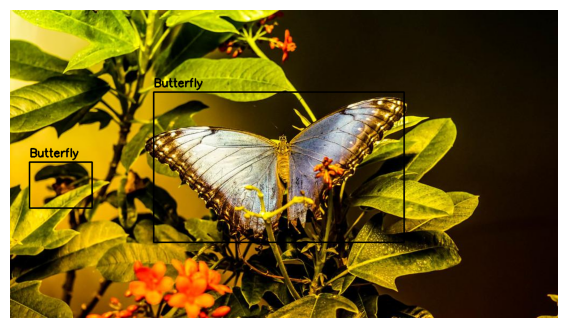

Class: Butterfly, Confidence: 0.9979336261749268


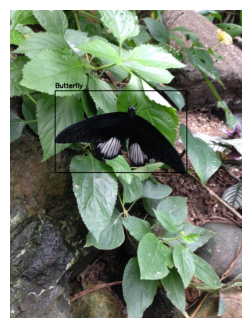

Class: Butterfly, Confidence: 0.9983779191970825
Class: Butterfly, Confidence: 0.9968675971031189
Class: Butterfly, Confidence: 0.898148775100708
Class: Butterfly, Confidence: 0.8413668870925903
Class: Butterfly, Confidence: 0.779662013053894


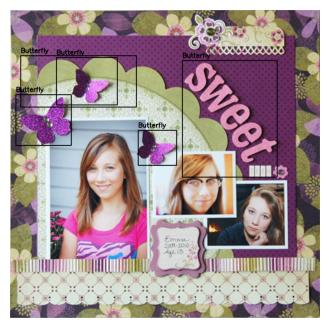

Class: Butterfly, Confidence: 0.9793492555618286


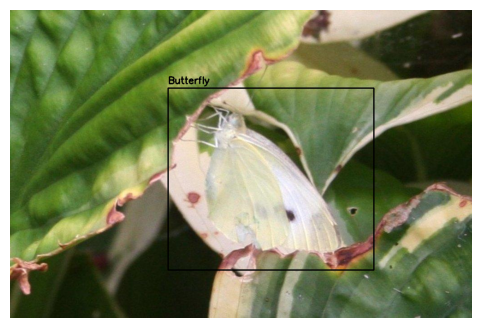

Class: Butterfly, Confidence: 0.9992683529853821
Class: Butterfly, Confidence: 0.9987982511520386
Class: Butterfly, Confidence: 0.9976546168327332


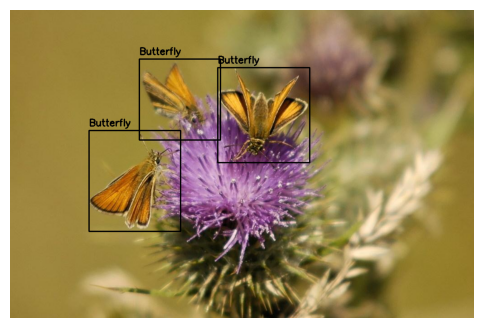

Class: Butterfly, Confidence: 0.9973646998405457
Class: Butterfly, Confidence: 0.9338131546974182
Class: Butterfly, Confidence: 0.7416664958000183


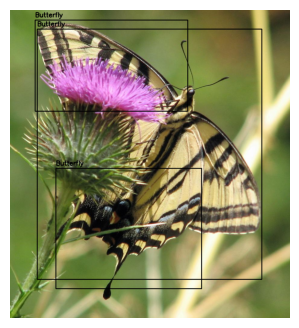

Class: Butterfly, Confidence: 0.9960339665412903
Class: Butterfly, Confidence: 0.9181978702545166
Class: Butterfly, Confidence: 0.7985081672668457


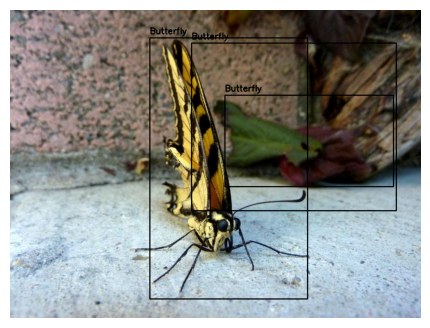

Class: Butterfly, Confidence: 0.9984164237976074


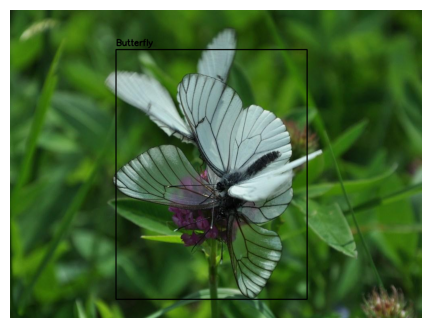

Class: Butterfly, Confidence: 0.998809814453125
Class: Butterfly, Confidence: 0.9795873165130615


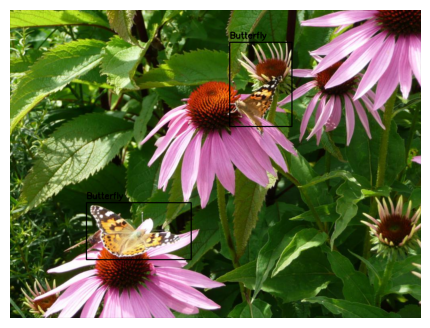

In [ ]:
for filename in val_filenames:
  VisualizePredictionPlate(filename, modelForSimpleAugTraining, idToName={1: 'Butterfly'}, thresh=0.5)

По визуальным результатам модели, обученной на датасете с простыми аугментациями, не затрагивающими bounding box, можно заметить, что предсказываются с достаточно большой степенью уверенности объекты, которые никак не относятся к классу бабочек. Так же есть повторяющиеся рамки. Увеличение threshhold немного улучшит ситуацию. Но Что делать с картинками, где неправильная детекция с уверенностью 0,91? Ведь есть же картинки, где правильная детекция с уверенностью 0,89. Получается, мы потеряем правильные предсказания. Определённо такой аугментации недостаточно.

### Визуализация результатов модели, обученной на датасете с только сложными аугментациями

Class: Butterfly, Confidence: 0.9970059990882874


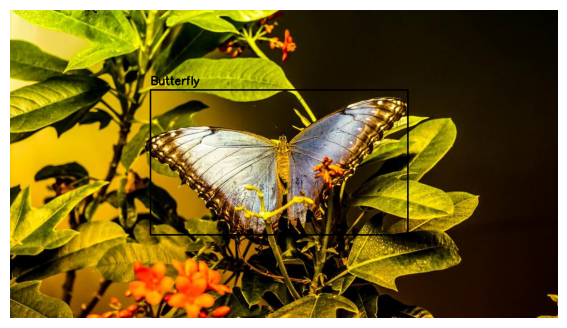

Class: Butterfly, Confidence: 0.9940974712371826


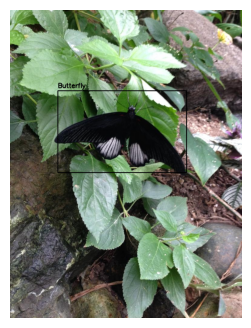

Class: Butterfly, Confidence: 0.9866178631782532
Class: Butterfly, Confidence: 0.9673470258712769
Class: Butterfly, Confidence: 0.6449556350708008


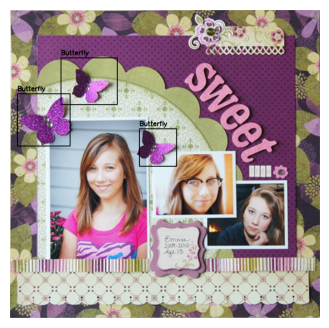

Class: Butterfly, Confidence: 0.8157745599746704


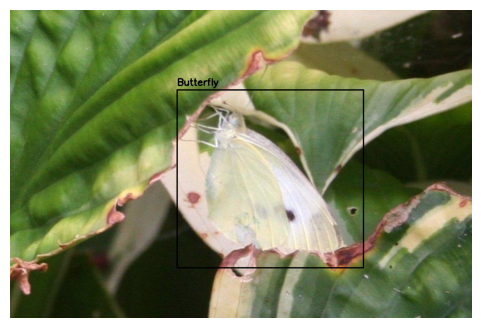

Class: Butterfly, Confidence: 0.9989449381828308
Class: Butterfly, Confidence: 0.9986836314201355
Class: Butterfly, Confidence: 0.9911378026008606


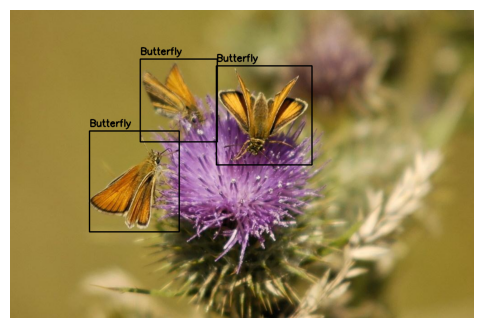

Class: Butterfly, Confidence: 0.9978134632110596
Class: Butterfly, Confidence: 0.803990364074707
Class: Butterfly, Confidence: 0.6759295463562012


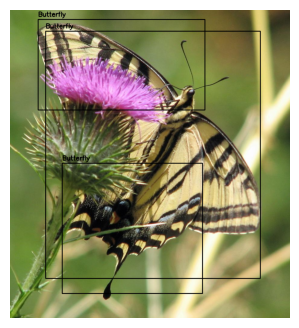

Class: Butterfly, Confidence: 0.9973337650299072


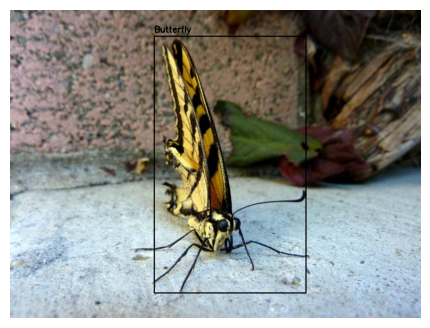

Class: Butterfly, Confidence: 0.9979630708694458


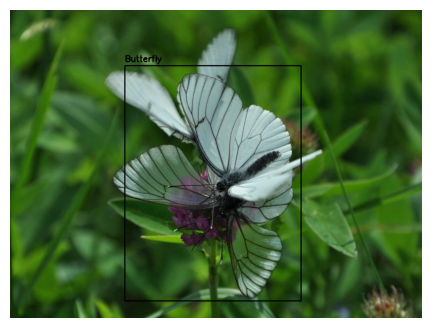

Class: Butterfly, Confidence: 0.9983137845993042
Class: Butterfly, Confidence: 0.961055338382721


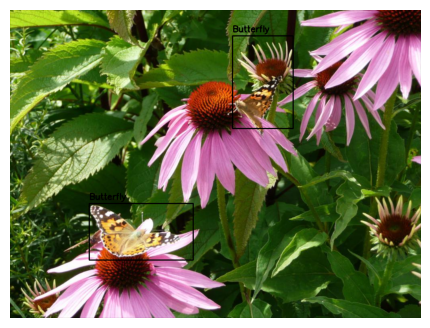

In [ ]:
for filename in val_filenames:
  VisualizePredictionPlate(filename, modelForHardAugTraining, idToName={1: 'Butterfly'}, thresh=0.5)

По визуальным результатам модели, обученной на датасете с только сложными аугментациями, затрагивающими bounding box, можно заметить, что результаты стали заметно лучше, чем на модели с простыми аугментациями, при таком же пороге = 0,5. На данных картинках уже нет выделения объектов, которые не относятся к классу бабочек, что очень хорошо. Но всё ещё не идеально, так как если бабочки расположены достаточно близко друг к другу, ещё и с распахнутыми крылышками, то они не детектируются по отдельности. Да и если бабочка ещё чем-то закрыта, то на ней могут детектироваться посторонние объёкты. Уже очевидно, что нужно было бы ещё добавить аугментацию вырезания квадрата из части бабочки. Так что один путь для улучшения уже найден.

### Визуализация результатов модели, обученной на датасете с простыми и сложными аугментациями в совокупности

Class: Butterfly, Confidence: 0.9958676099777222


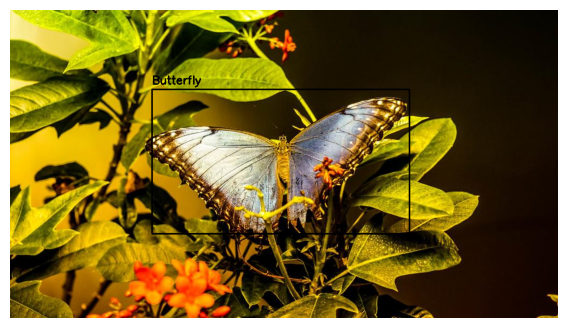

Class: Butterfly, Confidence: 0.9912874102592468


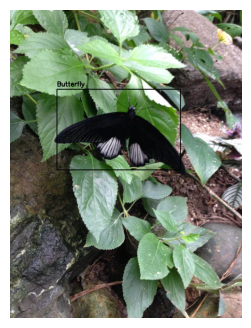

Class: Butterfly, Confidence: 0.9751487374305725
Class: Butterfly, Confidence: 0.9400184154510498
Class: Butterfly, Confidence: 0.7612962126731873
Class: Butterfly, Confidence: 0.5002745389938354


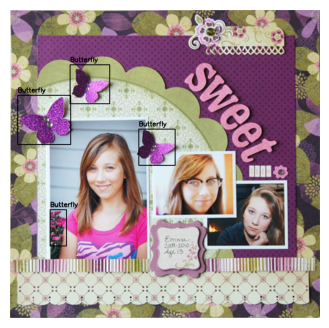

Class: Butterfly, Confidence: 0.6024794578552246


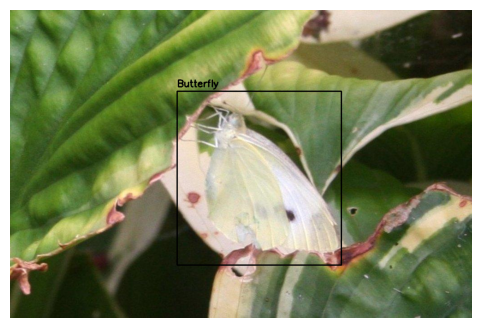

Class: Butterfly, Confidence: 0.9980460405349731
Class: Butterfly, Confidence: 0.9968006610870361
Class: Butterfly, Confidence: 0.9643415212631226


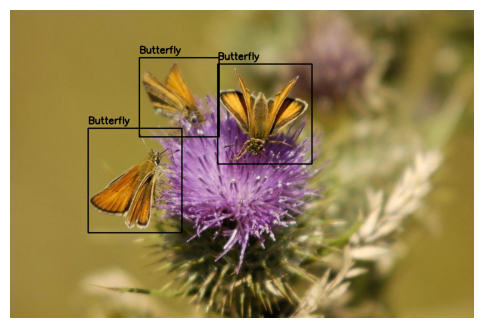

Class: Butterfly, Confidence: 0.9963831901550293
Class: Butterfly, Confidence: 0.6946450471878052


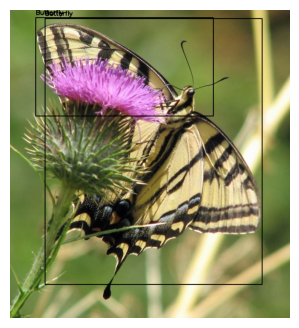

Class: Butterfly, Confidence: 0.9911392331123352
Class: Butterfly, Confidence: 0.5967876315116882


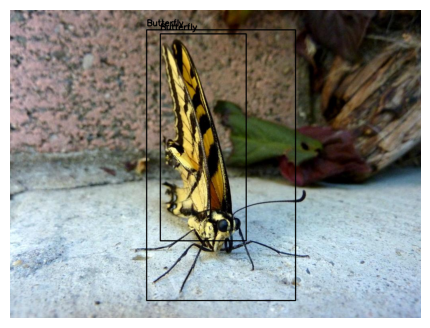

Class: Butterfly, Confidence: 0.9978200197219849


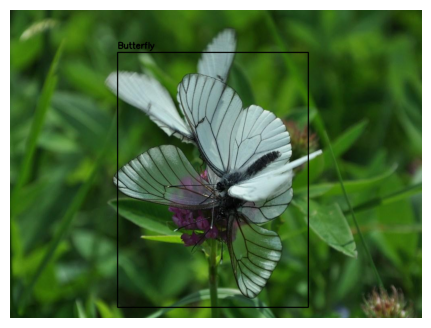

Class: Butterfly, Confidence: 0.9910857081413269
Class: Butterfly, Confidence: 0.8250008821487427


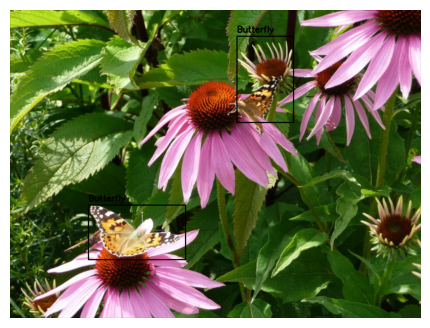

In [ ]:
for filename in val_filenames:
  VisualizePredictionPlate(filename, modelForAllAugTraining, idToName={1: 'Butterfly'}, thresh=0.5)

По визуальным результатам модели, обученной на датасете с простыми и сложными аугментациями, можно заметить, что результаты стали скорее немного лучше, чем на модели с только сложными аугментациями. Но это при условии, если увеличить порог до 0,7. Если бабочка чем-то слегка прикрыта, то при пороге 0,7 на данных примерах она будет детектиться нормально, без посторонних областей. Изменение threshhold во время визуального анализа, как нам говорили на лекции, это нормальная практика, так как он по сути подбирается эмпирически. А так, рамки стали, на мой взгляд, немного плотнее прижиматься краями к целевым областям, чем в модели с только сложными аугментациями. Это можно сравнить по картинке с фотографиями девочки.

## Выводы

Таким образом, была обучена модель Faster RCNN, которая была обучена на датасете COCO, на классе, который не содержался в COCO.
По статистике обучения видно, что аугментации в целом помогли. Но по качеству сложная аугментация, затрагивающия bounding box, оказалась производительнее, чем аугментация, не затрагивающая bounding box.
В совокупности модель со всеми аугментацииями оказалась лишь немного лучше модели с только сложными аугментациями, и то - с некоторыми оговорками. Оговорки в том, что можно было бы добавить аугментацию частичного перекрытия бабочки, и посмотреть результат.
Открытым остаётся вопрос, как классифицировать бабочек, находящихся вместе, крылья которых пересекаются. Возможно нужно больше фотографий именно таких, так как мне кажется, что таких фотографий в данном датасете очень мало и модель просто такие ситуации не в состоянии распознать.